#**Prep**

##*Install Stellargraph library*

In [ ]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.1.0

     |████████████████████████████████| 414 kB 30.7 MB/s 
     |████████████████████████████████| 500 kB 63.2 MB/s 
     |████████████████████████████████| 120 kB 70.0 MB/s 
     |████████████████████████████████| 1.6 MB 92.6 MB/s 
     |████████████████████████████████| 82 kB 616 kB/s 
     |████████████████████████████████| 41 kB 717 kB/s 


In [ ]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.1.0")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.1.0, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [ ]:
import stellargraph as sg
from stellargraph import StellarGraph

import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import networkx as nx
import math

from IPython.display import display, HTML

##*Load dataset*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle
# Load graph
with open("/content/drive/MyDrive/THESIS - SNG/01. DATASET/final dataset/stellargraphs_final_nofeatures.p", 'rb') as f:  # notice the r instead of w
    sgraphs = pickle.load(f)

In [ ]:
print(sgraphs[8].info())

StellarGraph: Undirected multigraph
 Nodes: 32, Edges: 37

 Node types:
  default: [32]
    Features: float32 vector, length 1
    Edge types: default-default->default

 Edge types:
    default-default->default: [37]
        Weights: range=[19.183, 413.643], mean=118.552, std=90.9021
        Features: none


In [ ]:
summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in sgraphs],
    columns=["nodes", "edges"],
)
summary.describe().round(1)

,nodes,edges
count,406.0,406.0
mean,70.0,97.5
std,45.4,70.9
min,10.0,13.0
25%,39.0,48.0
50%,59.5,76.5
75%,92.0,134.0
max,399.0,530.0


#**Main**

## *Create the model*

In [ ]:
generator = sg.mapper.PaddedGraphGenerator(sgraphs)

In [ ]:
gc_model = sg.layer.GCNSupervisedGraphClassification(
    [64, 32], ["relu", "relu"], generator, pool_all_layers=True
)

In [ ]:
inp1, out1 = gc_model.in_out_tensors()
inp2, out2 = gc_model.in_out_tensors()

vec_distance = tf.norm(out1 - out2, axis=1)

In [ ]:
pair_model = keras.Model(inp1 + inp2, vec_distance)
embedding_model = keras.Model(inp1, out1)

## *Train the model*

### Similarity measure

In [ ]:
def graph_distance(graph1, graph2):
    spec1 = nx.laplacian_spectrum(graph1.to_networkx(feature_attr=None))
    spec2 = nx.laplacian_spectrum(graph2.to_networkx(feature_attr=None))
    k = min(len(spec1), len(spec2))
    return np.linalg.norm(spec1[:k] - spec2[:k])

### Train

In [ ]:
train_nr = 200
graph_idx = np.random.RandomState(0).randint(len(sgraphs), size=(train_nr, 2))

In [ ]:
targets = [graph_distance(sgraphs[left], sgraphs[right]) for left, right in graph_idx]

In [ ]:
train_gen = generator.flow(graph_idx, batch_size=10, targets=targets)

## *Training procedure*

In [ ]:
pair_model.compile(keras.optimizers.Adam(1e-2), loss="mse")

CPU times: user 2min 54s, sys: 12 s, total: 3min 6s
Wall time: 2min 31s


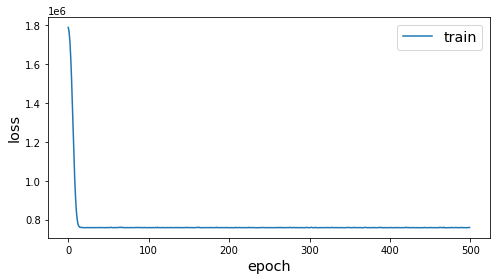

In [ ]:
%%time
history = pair_model.fit(train_gen, epochs=500, verbose=0)
sg.utils.plot_history(history)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

##*Compute embeddings*

In [ ]:
embeddings = embedding_model.predict(generator.flow(sgraphs))

In [ ]:
embeddings

array([[  18.175621,    0.      ,    0.      , ..., 1842.5072  ,
        1836.7664  ,    0.      ],
       [  18.452213,    0.      ,    0.      , ..., 1869.9485  ,
        1864.1588  ,    0.      ],
       [  18.600067,    0.      ,    0.      , ..., 1887.3309  ,
        1881.509   ,    0.      ],
       ...,
       [  19.655722,    0.      ,    0.      , ..., 1995.246   ,
        1989.2303  ,    0.      ],
       [  18.371908,    0.      ,    0.      , ..., 1863.5787  ,
        1857.7993  ,    0.      ],
       [  18.044628,    0.      ,    0.      , ..., 1831.2186  ,
        1825.4965  ,    0.      ]], dtype=float32)

#**Analysis of embeddings**

##*Tsne visualization*

In [ ]:
import cv2
import os
import glob
from google.colab.patches import cv2_imshow

def load_images_from_folder(folder):
    images = []
    filenames = glob.glob(os.path.join(folder,"*"))
    for i in range(0,len(filenames)):
      img = cv2.imread(os.path.join(folder,'{}.png'.format(i)))
      if img is not None:
        img = cv2.resize(img, (150, 150))   
        images.append(img)
    return images

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
tsne = TSNE(2)
two_d = tsne.fit_transform(embeddings)

In [ ]:
two_d_scaled = StandardScaler().fit_transform(two_d)

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def visualize_scatter_with_images(X_2d_data, images, figsize=(100,100), image_zoom=1):
    fig, ax = plt.subplots(figsize=figsize)
    artists = []
    for xy, i in zip(X_2d_data, images):
        x0, y0 = xy
        img = OffsetImage(i, zoom=image_zoom)
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(X_2d_data)
    ax.autoscale()
    plt.show()


In [ ]:
images = load_images_from_folder('/content/drive/MyDrive/THESIS - SNG/01. DATASET/final dataset/plots')

In [ ]:
visualize_scatter_with_images(two_d_scaled, images, image_zoom=1)

## *K-means Clustering*

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import kelbow_visualizer
scaler = StandardScaler()

In [ ]:
#scale all the values
X= scaler.fit_transform(embeddings)

In [ ]:
# we see in how many groups our data can be clustered
kelbow_visualizer(KMeans(random_state=4), X, k=(2,20), timings=False)

In [ ]:
#initialize the kmeans model
kmeans = KMeans(n_clusters=5, random_state=42 ,algorithm="elkan").fit(X)

In [ ]:
#run the model on our data
y_kmeans = kmeans.predict(X)

In [ ]:
# Labels for each row
labels= kmeans.labels_
print(labels)

###Load images

In [ ]:
import cv2
import os
import glob
from google.colab.patches import cv2_imshow

def load_images_from_folder(folder):
    images = []
    filenames = glob.glob(os.path.join(folder,"*"))
    for i in range(0,len(filenames)):
      img = cv2.imread(os.path.join(folder,'{}.png'.format(i)))
      if img is not None:
        img = cv2.resize(img, (150, 150))   
        images.append(img)
    return images

In [ ]:
images = load_images_from_folder('/content/drive/MyDrive/THESIS - SNG/01. DATASET/final dataset/plots')
len(images)

In [ ]:
#for 5 clusters 
for i in range(0,5):
  print('label           == {}'.format(i))
  result = np.where(labels == i)
  resimg = [images[i] for i in result[0]]
  for img in resimg:
    cv2_imshow(img)